## Low-level concepts comparison

In [14]:
import os
#virtually move to parent directory
os.chdir("..")


In [16]:
import torch
import matplotlib
from matplotlib import pyplot as plt

import utils
import data_utils
import similarity

This notebook only reproduces CLIP-Dissect, MILAN results were obtained using their repo

## Settings

In [17]:
clip_name = 'ViT-B/16'
d_probe = 'imagenet_val'
concept_set = 'data/20k.txt'
batch_size = 200
device = 'cuda'
pool_mode = 'max'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi

In [18]:
target_name = 'resnet152'
target_layers = ['conv1', 'layer1']
neurons_to_display = [[1,2,3,10,12,16,24,28], [3,4]]

## Run CLIP-Dissect

In [19]:
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = target_layers, 
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size, 
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

with open(concept_set, 'r') as f: 
    words = (f.read()).split('\n')

pil_data = data_utils.get_data(d_probe)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /tmp/xdg-cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:00<00:00, 353MB/s] 
100%|██████████| 250/250 [01:18<00:00,  3.17it/s]


## Conv1

In [20]:
save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layers[0], d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name, 
                                                                text_save_name, similarity_fn, device=device)

100%|██████████| 64/64 [00:02<00:00, 22.93it/s]

torch.Size([64, 20000])


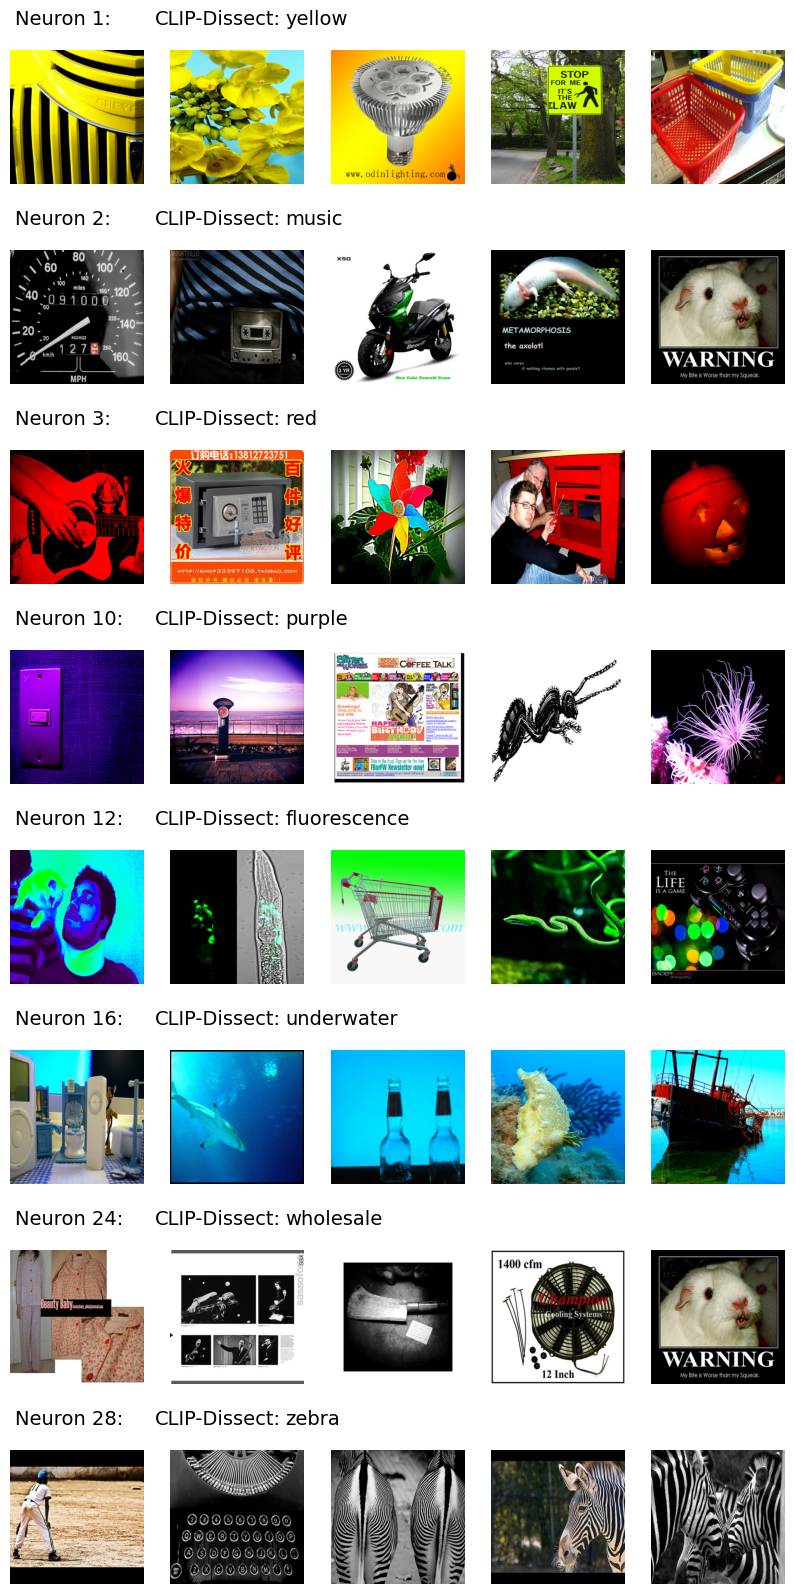

In [21]:
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)
neurons_to_check = neurons_to_display[0]
font_size=14
font = {'size'   : font_size}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, len(neurons_to_check)*2])#constrained_layout=True)
subfigs = fig.subfigures(nrows=len(neurons_to_check), ncols=1)
for j, orig_id in enumerate(neurons_to_check):
    vals, ids = torch.topk(similarities[orig_id], k=5, largest=True)
        
    subfig = subfigs[j]
    subfig.text(0.13, 0.96, "Neuron {}:".format(int(orig_id)), size=font_size)
    subfig.text(0.27, 0.96, "CLIP-Dissect:", size=font_size)
    subfig.text(0.4, 0.96, words[int(ids[0])], size=font_size)
    axs = subfig.subplots(nrows=1, ncols=5)
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        axs[i].imshow(im)
        axs[i].axis('off')
plt.show()

## Layer 1

In [22]:
save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layers[1], d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name, 
                                                                text_save_name, similarity_fn, device=device)

100%|██████████| 256/256 [00:10<00:00, 23.68it/s]

torch.Size([256, 20000])


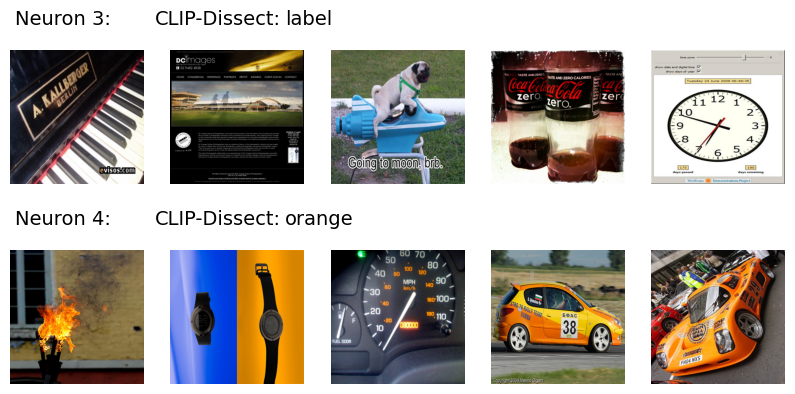

In [23]:
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)
neurons_to_check = neurons_to_display[1]
font_size=14
font = {'size'   : font_size}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, len(neurons_to_check)*2])#constrained_layout=True)
subfigs = fig.subfigures(nrows=len(neurons_to_check), ncols=1)
for j, orig_id in enumerate(neurons_to_check):
    vals, ids = torch.topk(similarities[orig_id], k=5, largest=True)
        
    subfig = subfigs[j]
    subfig.text(0.13, 0.96, "Neuron {}:".format(int(orig_id)), size=font_size)
    subfig.text(0.27, 0.96, "CLIP-Dissect:", size=font_size)
    subfig.text(0.4, 0.96, words[int(ids[0])], size=font_size)
    axs = subfig.subplots(nrows=1, ncols=5)
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        axs[i].imshow(im)
        axs[i].axis('off')
plt.show()

In [ ]:
#Load MILAN results
milan_base = pd.read_csv('data/MILAN_results/m_base_{}.csv'.format(name_conversion[target_name]))
if target_name == 'resnet50':
    milan_ood = pd.read_csv('data/MILAN_results/m_places365_{}.csv'.format(name_conversion[target_name]))
elif target_name == 'resnet18_places':
    milan_ood = pd.read_csv('data/MILAN_results/m_imagenet_{}.csv'.format(name_conversion[target_name]))

milan_base = milan_base[milan_base['layer']==target_layer]
milan_base = milan_base.sort_values(by=['unit'])
milan_base = list(milan_base['description'])

milan_ood = milan_ood[milan_ood['layer']==target_layer]
milan_ood = milan_ood.sort_values(by=['unit'])
milan_ood = list(milan_ood['description'])

    # subfig.text(0.13, 0.85, "MILAN(b):", size=font_size)
    # subfig.text(0.24, 0.85, milan_base[orig_id], size=font_size, color=get_color("milan_b", j))